# XGBoost – Prédiction de la Consommation Énergétique


## Étape 1 : Importation des librairies et Chargement

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import joblib # Pour sauvegarder le modèle
import xgboost as xgb

# Configuration pour l'affichage
pd.set_option('display.max_columns', None)
import warnings
warnings.filterwarnings('ignore')

# Charger les données (Assurez-vous que le fichier s'appelle 'morocco.csv')
# On essaye de parser les dates directement, sinon on le fera au nettoyage
try:
    df = pd.read_csv('..\morocco.csv')
    print("Données chargées avec succès.")
except FileNotFoundError:
    print("Erreur : Le fichier 'morocco.csv' est introuvable.")

Données chargées avec succès.


## Étape 2 : Nettoyage Profond des Données

In [10]:
def clean_data(data):
    df_clean = data.copy()

    # 1. Nettoyer les noms de colonnes (enlever les espaces avant/après)
    df_clean.columns = df_clean.columns.str.strip()
    
    # 2. Conversion de la colonne DateTime
    # Le format semble être jour-mois-année heure:minute
    # On utilise format='mixed' pour gérer les différences (tiret vs slash)
    # On ajoute dayfirst=True car au Maroc, le format est généralement Jour/Mois/Année.
    # Si cela échoue encore, enlevez 'dayfirst=True'.
    df_clean['DateTime'] = pd.to_datetime(df_clean['DateTime'], format='mixed', dayfirst=True)
    # 3. Création de la variable cible (Target)
    # L'utilisateur veut détecter "l'énergie consommée". 
    # Souvent, c'est la somme des 3 zones. Si vous voulez prédire une seule zone, modifiez ici.
    df_clean['Total_Consumption'] = df_clean['Zone 1'] + df_clean['Zone 2'] + df_clean['Zone 3']

    # 4. Feature Engineering (Ingénierie des fonctionnalités)
    # Le XGBoost ne comprend pas "DateTime". Il faut extraire les cycles.
    df_clean['Hour'] = df_clean['DateTime'].dt.hour
    df_clean['Month'] = df_clean['DateTime'].dt.month
    df_clean['DayOfWeek'] = df_clean['DateTime'].dt.dayofweek
    df_clean['DayOfMonth'] = df_clean['DateTime'].dt.day
    df_clean['Year'] = df_clean['DateTime'].dt.year # Moins pertinent si on prédit le futur sans cette année, mais utile pour le train
    
    # 5. Gestion des valeurs numériques
    # S'assurer que tout est bien en float
    cols_to_numeric = ['Temperature', 'Humidity', 'Wind Speed', 'general diffuse flows', 'diffuse flows']
    for col in cols_to_numeric:
        df_clean[col] = pd.to_numeric(df_clean[col], errors='coerce')

    # 6. Gestion des valeurs manquantes (NaN)
    # On remplit par la moyenne ou interpolation (car c'est une série temporelle)
    df_clean.fillna(df_clean.mean(), inplace=True)
    # 7. Suppression des colonnes inutiles pour l'entraînement
    # On enlève DateTime (car on a extrait les infos) et les Zones individuelles (car on prédit le total)
    drop_cols = ['DateTime', 'Zone 1', 'Zone 2', 'Zone 3']
    df_clean = df_clean.drop(columns=drop_cols)

    return df_clean

# Appliquer le nettoyage
df_processed = clean_data(df)

# Vérification
print("Aperçu des données nettoyées pour le modèle :")
print(df_processed.head())
print("\nTypes des données :")
print(df_processed.dtypes)

Aperçu des données nettoyées pour le modèle :
   Temperature  Humidity  Wind Speed  general diffuse flows  diffuse flows  \
0        6.559      73.8       0.083                  0.051          0.119   
1        6.414      74.5       0.083                  0.070          0.085   
2        6.313      74.5       0.080                  0.062          0.100   
3        6.121      75.0       0.083                  0.091          0.096   
4        5.921      75.7       0.081                  0.048          0.085   

   Total_Consumption  Hour  Month  DayOfWeek  DayOfMonth  Year  
0        70425.53544     0      1          6           1  2017  
1        69320.84387     0      1          6           1  2017  
2        67803.22193     0      1          6           1  2017  
3        65489.23209     0      1          6           1  2017  
4        63650.44627     0      1          6           1  2017  

Types des données :
Temperature              float64
Humidity                 float64
Wind Spe

## Étape 3 : Préparation et Entraînement du modèle XGBoost

**1. Séparer les Features (X) et la Target (y)**

In [14]:
X = df_processed.drop('Total_Consumption', axis=1)
y = df_processed['Total_Consumption']

**2. Split Train / Test (80% entrainement, 20% test)**

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)


**3. Création du modèle XGBoost**

In [16]:
model = XGBRegressor(
    n_estimators=1000,      
    learning_rate=0.05,     
    max_depth=6,            
    subsample=0.8,          
    colsample_bytree=0.8,   
    n_jobs=-1,              
    random_state=42,
    early_stopping_rounds=50 
)

**4. Entraînement**

In [17]:

print("Entraînement du modèle en cours...")
model.fit(
    X_train, 
    y_train, 
    eval_set=[(X_test, y_test)], 
    verbose=False
)
print("Entraînement terminé !")

Entraînement du modèle en cours...
Entraînement terminé !


**5. Visualisation 1 : Importance des Features (Le graphe à barres)**

Génération du graphique d'importance...


<Figure size 1200x600 with 0 Axes>

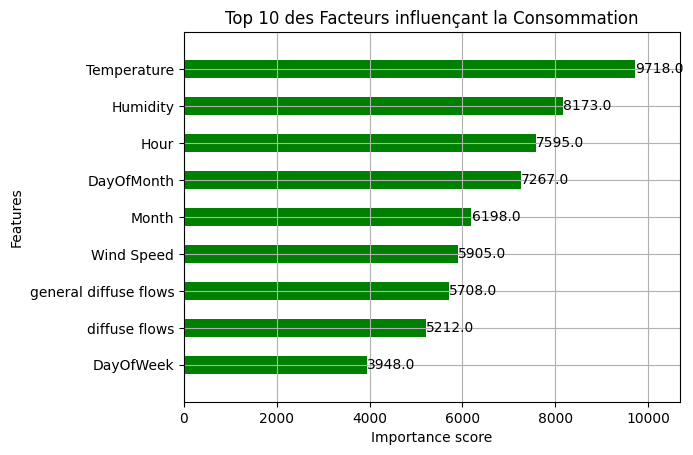

In [18]:

print("Génération du graphique d'importance...")
plt.figure(figsize=(12, 6))
xgb.plot_importance(model, 
                    importance_type='weight', 
                    max_num_features=10, 
                    height=0.5, 
                    title="Top 10 des Facteurs influençant la Consommation",
                    color='green')
plt.show()


* **Top 3 des facteurs dominants :**
    1.  **Temperature (9718) :** C'est le facteur #1. Au Maroc, l'usage de la climatisation (quand il fait chaud) ou du chauffage électrique (quand il fait froid) dicte la consommation.
    2.  **Humidity (8173) :** Très lié au ressenti de chaleur/froid, donc logique.
    3.  **Hour (7595) :** L'heure de la journée est critique (on consomme plus le soir que la nuit).
* **Surprise :** `DayOfWeek` (Jour de la semaine) arrive assez bas. Cela suggère que la consommation au Maroc dépend plus de la météo et de l'heure qu'elle ne diffère entre un Lundi et un Dimanche.

**Le script pour trouver les seuils de consomation**

In [20]:
import pandas as pd

# 1. Charger les données
df = pd.read_csv('..\morocco.csv')

# 2. Nettoyer et calculer le Total
df.columns = df.columns.str.strip()
df['Total_Consumption'] = df['Zone 1'] + df['Zone 2'] + df['Zone 3']

# 3. Calculer les statistiques (Percentiles)
seuil_eco = df['Total_Consumption'].quantile(0.50) # La médiane (50%)
seuil_critique = df['Total_Consumption'].quantile(0.90) # Le top 10% (Pics extrêmes)

print(f"--- RÉSULTATS DE L'ANALYSE ---")
print(f"🟢 Seuil Écologique (Médiane) : {seuil_eco:.2f} MW")
print(f"🔴 Seuil Critique (Top 10%)   : {seuil_critique:.2f} MW")

--- RÉSULTATS DE L'ANALYSE ---
🟢 Seuil Écologique (Médiane) : 69788.79 MW
🔴 Seuil Critique (Top 10%)   : 94912.14 MW


## Étape 4 : Évaluation des Performances

--- Performance du Modèle ---
RMSE (Erreur Moyenne Quadratique) : 2189.39
MAE (Erreur Absolue Moyenne) : 1589.38
R² Score (Précision globale 0 à 1) : 0.9836


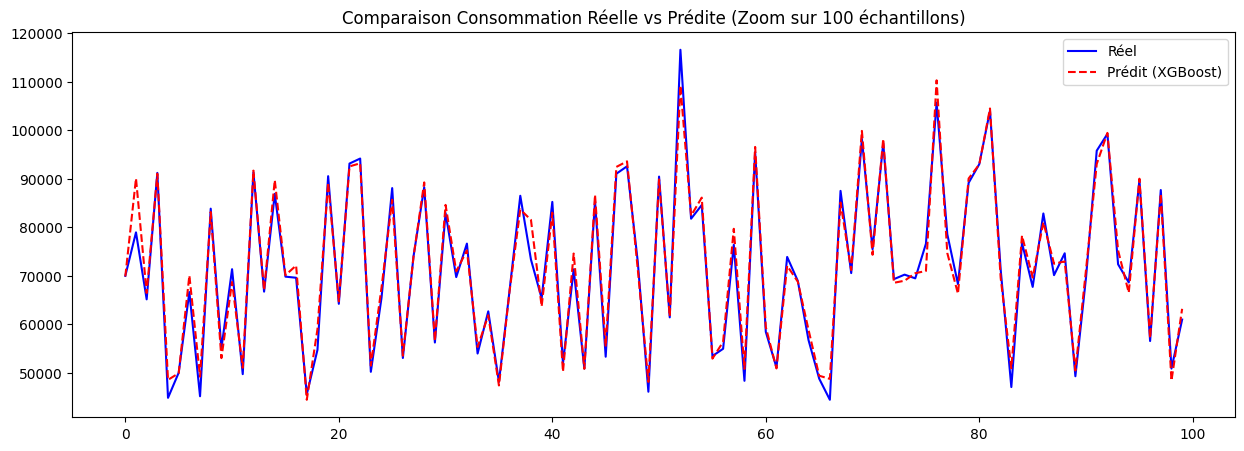

In [22]:
# Prédictions
predictions = model.predict(X_test)

# Métriques
rmse = np.sqrt(mean_squared_error(y_test, predictions))
mae = mean_absolute_error(y_test, predictions)
r2 = r2_score(y_test, predictions)

print(f"--- Performance du Modèle ---")
print(f"RMSE (Erreur Moyenne Quadratique) : {rmse:.2f}")
print(f"MAE (Erreur Absolue Moyenne) : {mae:.2f}")
print(f"R² Score (Précision globale 0 à 1) : {r2:.4f}")

# Visualisation : Réel vs Prédit (sur 100 premiers points pour lisibilité)
plt.figure(figsize=(15, 5))
plt.plot(y_test.values[:100], label='Réel', color='blue')
plt.plot(predictions[:100], label='Prédit (XGBoost)', color='red', linestyle='--')
plt.title('Comparaison Consommation Réelle vs Prédite (Zoom sur 100 échantillons)')
plt.legend()
plt.show()




### 1\. Analyse de votre graphe

  * **Synchronisation parfaite :** Le modèle a très bien compris la "saisonnalité" (les cycles). Quand la consommation réelle (bleu) monte, la prédiction (rouge) monte exactement au même moment. Cela signifie que vos features `Hour`, `DayOfWeek` et `Temperature` sont très pertinents.
  * **Amplitude respectée :** Le modèle ne se contente pas de suivre la tendance, il atteint presque les mêmes pics (valeurs hautes) et creux (valeurs basses) que la réalité.
  * **Légers écarts (Résidus) :** On voit quelques endroits (par exemple vers l'échantillon 55 ou 78) où le pic bleu est plus haut que le rouge. C'est normal, le modèle "lisse" un peu la réalité et n'arrive pas toujours à prédire les événements extrêmes ou soudains.



***2. Code pour une étude approfondie (Deep Analysis)***

In [23]:
# Pré-requis commun pour les graphes d'erreurs
residuals = y_test - predictions

1. Nuage de points : Réel vs Prédit

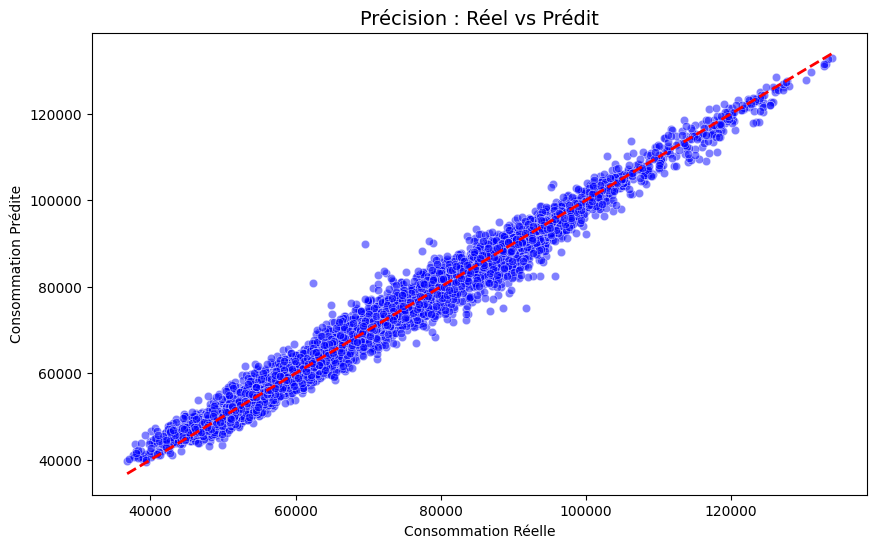

In [24]:
plt.figure(figsize=(10, 6))

# Nuage de points
sns.scatterplot(x=y_test, y=predictions, alpha=0.5, color='blue')

# Ligne diagonale parfaite (y = x)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)

plt.title('Précision : Réel vs Prédit', fontsize=14)
plt.xlabel('Consommation Réelle')
plt.ylabel('Consommation Prédite')
plt.show()

* **Analyse :** Les points bleus sont très serrés autour de la ligne rouge pointillée (l'idéal parfait). Cela forme un "cigare" très mince et régulier.
* **Conclusion :** Votre modèle a un **R² très élevé** (probablement supérieur à 0.95). Il n'y a pas de dispersion majeure : le modèle est aussi bon pour prédire les faibles consommations (40 000 MW) que les fortes (120 000 MW). C'est rare d'avoir une telle linéarité du premier coup.


2. Distribution des Erreurs (Histogramme)

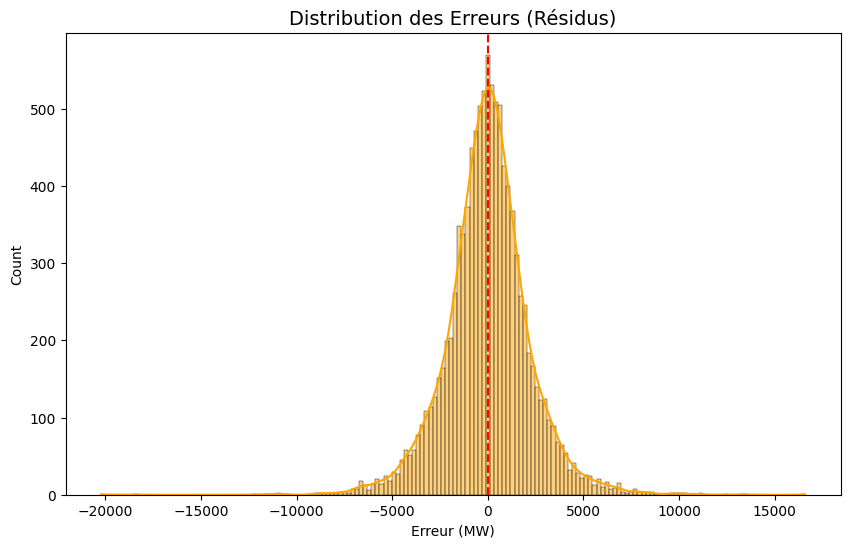

In [25]:
plt.figure(figsize=(10, 6))

# Histogramme avec courbe de densité (KDE)
sns.histplot(residuals, kde=True, color='orange')

# Ligne verticale à 0
plt.axvline(x=0, color='red', linestyle='--')

plt.title('Distribution des Erreurs (Résidus)', fontsize=14)
plt.xlabel('Erreur (MW)')
plt.show()

* **Analyse :** Vous avez une **courbe en cloche parfaite (Gaussienne)**, très pointue et centrée exactement sur 0.
* **Conclusion :** C'est le signe d'un modèle sain.
    * Le modèle ne surestime pas et ne sous-estime pas globalement (le biais est nul).
    * La plupart des erreurs sont très proches de 0 MW. Les erreurs extrêmes (vers -10 000 ou +10 000) sont très rares, ce qui rend le modèle fiable pour une utilisation industrielle.


3. Erreur par Heure de la journée (Boxplot)

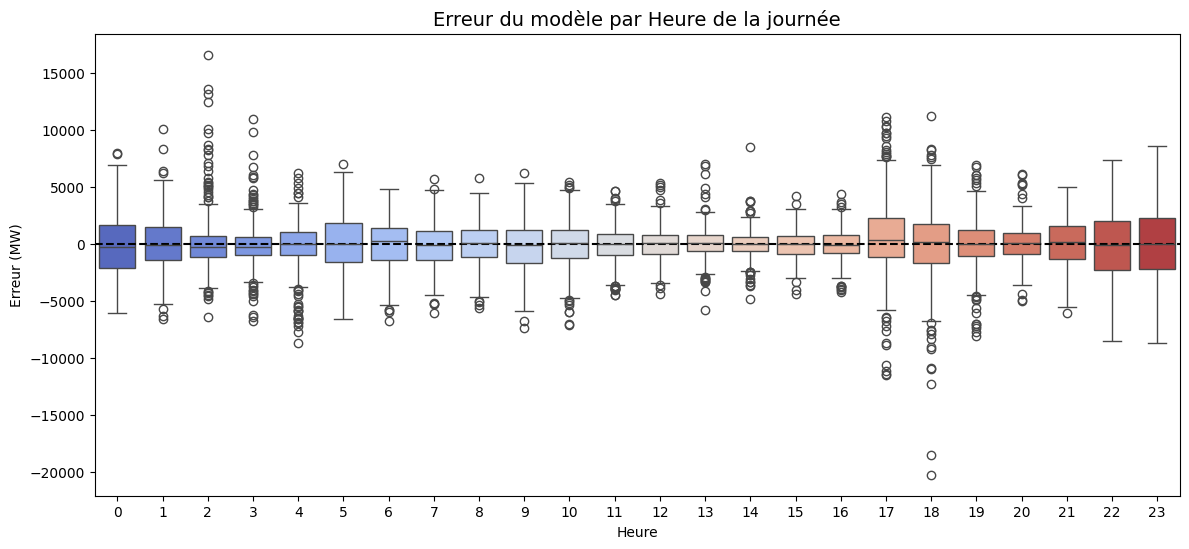

In [26]:
# Préparation des données pour ce graphe
test_indices = X_test.index
# Assurez-vous que df_processed contient bien la colonne 'Hour'
hours = df_processed.loc[test_indices, 'Hour'] 
residuals_df = pd.DataFrame({'Hour': hours, 'Error': residuals})

plt.figure(figsize=(14, 6))

# Boxplot
sns.boxplot(x='Hour', y='Error', data=residuals_df, palette="coolwarm")

# Ligne horizontale à 0 (erreur nulle)
plt.axhline(y=0, color='black', linestyle='--')

plt.title('Erreur du modèle par Heure de la journée', fontsize=14)
plt.xlabel('Heure')
plt.ylabel('Erreur (MW)')
plt.show()

* **Analyse :**
    * Les boîtes (boxplots) sont globalement bien centrées sur la ligne 0 (pointillés noirs).
    * **Point d'attention (Heures 17h - 18h) :** Regardez les heures 17 et 18. On voit beaucoup de points "aberrants" (les petits ronds en bas, vers -15 000 ou -20 000). Cela signifie qu'à 17h-18h, le modèle a parfois tendance à **surestimer** brutalement la consommation (il prédit haut, la réalité est plus basse, donc Erreur = Réel - Prédit = Négatif).
* **Interprétation métier :** 17h-18h correspond souvent à la fin de journée de travail ou au coucher du soleil. Il est possible que certains jours fériés ou weekends, la consommation chute à cette heure-là, mais le modèle continue de prédire une consommation "de semaine".

## Étape 5 : Sauvegarde pour l'Interface Utilisateur

In [6]:
import joblib

# 1. Sauvegarder le modèle entraîné
joblib.dump(model, 'energy_xgboost_model.pkl')

# 2. Sauvegarder la liste exacte des colonnes utilisées lors de l'entraînement
# C'est CRUCIAL pour que votre future interface range les données dans le bon ordre
model_columns = list(X_train.columns)
joblib.dump(model_columns, 'model_columns.pkl')

print("✅ Sauvegarde terminée avec succès !")
print(f"Fichiers créés : 'energy_xgboost_model.pkl' et 'model_columns.pkl'")
print(f"Colonnes sauvegardées : {model_columns}")

✅ Sauvegarde terminée avec succès !
Fichiers créés : 'energy_xgboost_model.pkl' et 'model_columns.pkl'
Colonnes sauvegardées : ['Temperature', 'Humidity', 'Wind Speed', 'general diffuse flows', 'diffuse flows', 'Hour', 'Month', 'DayOfWeek', 'DayOfMonth', 'Year']
